In [1]:
import sys
import os
sys.path.insert(0, '/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')
os.chdir('/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import kaepora as kpora
import numpy as np
import matplotlib.pyplot as plt

In [4]:
spectra_query = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source < 3) or (dm15_from_fits < 3)) and si_v0 >= -11000 and si_v0 <= -10000"]

In [5]:
spec_array = kpora.grab(spectra_query[0], db_file = '../data/kaepora_v1_DEV.db', make_corr = True)

191 Total Spectra found
4 flagged spectra removed 187 spectra left
0 spectra of peculiar Ias removed 187 spectra left
184 spectra of SNe that have host reddening corrections
Arrays cleaned


In [6]:
def fluxGrid(spec_array):
    
    MINSTART = spec_array[0].x1
    MINEND = spec_array[0].x2

    for spec in spec_array:
        if spec.x1 < MINSTART:
            MINSTART = spec.x1
        if spec.x2 > MINEND:
            MINEND = spec.x2
    
    all_data = 0.0

    for spec in spec_array:
        all_data += len(spec.flux[~np.isnan(spec.flux)])
    
    length = len(spec_array[0].flux[~np.isnan(spec_array[0].flux)])

    for spec in spec_array:
        if length > len(spec.flux[~np.isnan(spec.flux)]):
            length = len(spec.flux[~np.isnan(spec.flux)])
    
    total_data = all_data
    data_percent = 0.0

    start = MINSTART

    bestStart = None
    bestLength = None

    while (start + length - 1 <= MINEND):
        total_data = all_data

        while (start + length - 1 <= MINEND):
            num_cols = len(spec_array)
            
            for spec in spec_array:
                array_start = spec.flux[:start]
                array_end = spec.flux[(start + length - 1):]
                new_array = spec.flux[start:(start + length)]

                total_data -= len(array_start[~np.isnan(array_start)])
                total_data -= len(array_end[~np.isnan(array_end)])

                if any(np.isnan(new_array)):
                    total_data -= len(new_array[~np.isnan(new_array)])
                    num_cols -= 1

            new_data = total_data/all_data

            if new_data > data_percent:
                data_percent = new_data
                bestStart = start
                bestLength = length
                best_num_cols = num_cols

            total_data = all_data
            start += 100

        start = MINSTART 
        length += 100
    
    MIN = bestStart
    MAX = bestStart + bestLength - 1

    num_rows = bestLength
    num_cols = best_num_cols
    
    grid = []
    k = 0
    
    while len(grid) < num_cols:
        if any(np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            spec_array.pop(k)
        if all(~np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            grid.append(spec_array[k].flux[MIN:(MAX + 1)])
            k += 1
    
    print num_cols
    np.savetxt('../../Filtered_Flux_Grid_dm15', grid)
    
    print (MIN, MAX)
    
    print (spec_array[0].wavelength[MIN], spec_array[0].wavelength[MAX])
    return (MIN, MAX, grid)

In [7]:
MIN, MAX, grid = fluxGrid(spec_array)
spec_array = spec_array[:len(grid)]

160
(1461, 3056)
(3922.0, 7112.0)


After Sequencer:

In [8]:
data = np.loadtxt("../../dm15_Sequence")
data = data.astype(int)
print data

[ 11  21 125 124 123  59  60 157 156 155 154 153  16  15  17  69  70  14
  41  42  13  97  12  49  98  50  27  26  29  28  53   9   4  87   8  10
  25   7   6  88  86 128  89   5 110 109 111 114  90 152  48 108 112 151
  91 149  85  47  20  92 113 148  31  84 116  43  24  67 129 115 147  35
 117  30  22  19 137  44 105  68 136 118 146 106 150  34 107   2  23  71
  45 103  51 145  33  46   3  72 126 158 119  63  52  54 142  65   0  62
  77  32  66 143  73 104  78  18  75  61 120 122 144 159  80   1  79  76
  74 121  81  82 100  99 101 141  83 140 139  94 102 138 133  37  96 132
  38  36 131  95 134  39 130 135  57  40  58  64  55  56 127  93]


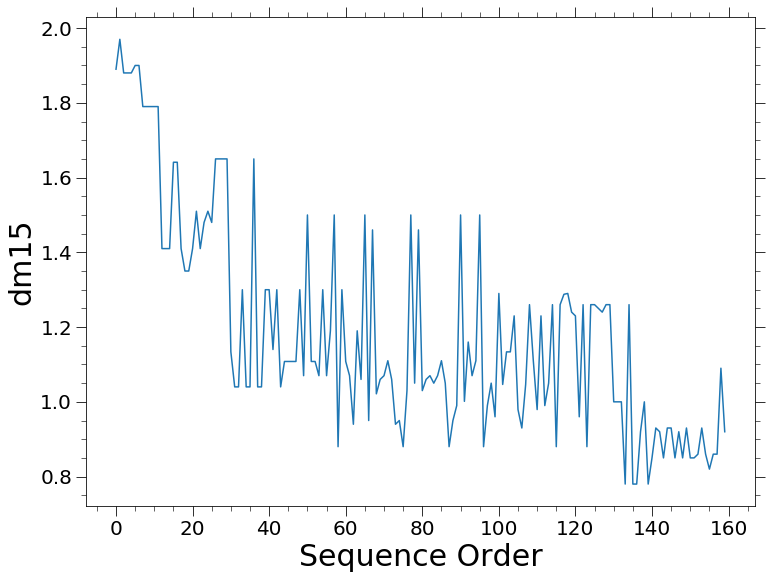

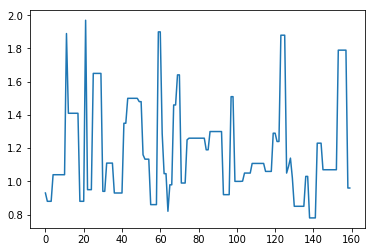

In [9]:
ordered_array = []

for i in data:
    ordered_array.append(spec_array[i].dm15)

plt.figure(figsize=(12,9))
plt.xlabel("Sequence Order", fontsize = 30)
plt.ylabel("dm15", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.plot(ordered_array)
plt.savefig('../../dm15_Plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

unordered_array = []

for spec in spec_array:
    unordered_array.append(spec.dm15)

plt.plot(unordered_array)
plt.show()

Outlier Diagnostic Tools:

158 1.09


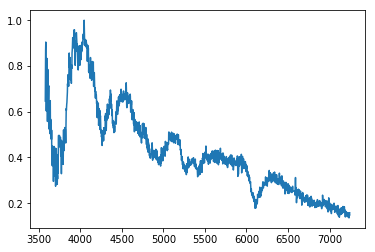

In [10]:
outlier_estimate = 155
y = 1

i = outlier_estimate - 5
k = outlier_estimate + 5

if k >= len(spec_array):
    k = len(spec_array) - 1

if i < 0:
    i = 0

while i <= k:
    if spec_array[data[i]].dm15 > y:
        wavelength = spec_array[data[i]].wavelength
        flux = spec_array[data[i]].flux
        plt.plot(wavelength, flux)
        print i, spec_array[data[i]].dm15
    i += 1

159 0.92
158 1.09
157 0.86
156 0.86
155 0.82


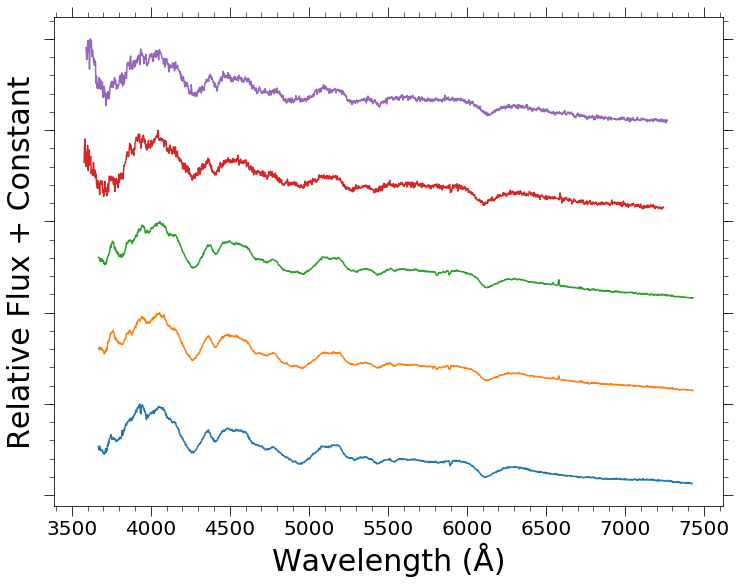

In [11]:
outlier = 158

i = outlier - 3
k = outlier + 3
j = 0

if k >= len(spec_array):
    k = len(spec_array) - 1

if i < 0:
    i = 0

plt.figure(figsize=(12,9))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

while i <= k:
    wavelength = spec_array[data[i]].wavelength
    flux = spec_array[data[i]].flux
    plt.plot(wavelength, flux + j)
    print k - j, spec_array[data[k - j]].dm15
    i += 1
    j += 1

plt.show()

Composites:

In [12]:
num_comp = 11

file_name_array = []
k = 0

while k < len(data):
    farray = []
    for i in data[k:k+len(data)/num_comp]:
        farray.append(spec_array[i].filename)
    file_name_array.append(farray)
    k += len(data)/num_comp

query_strings = []

for files in file_name_array:
    i = 1
    string = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where "
    for file in files:
        string += "filename = '%s'"% (file)
        if i < len(files):
            string += ' or '
        i += 1
    query_strings.append(string)

composites, sn_arrays, boot_sn_arrays = kpora.make_composite(query_strings, boot=False, medmean=1, gini_balance=True, verbose=False, shape_param='dm15', av_corr = False)

SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where filename = 'sn2007al-20070312.31-fast.flm' or filename = 'sn1999by-19990514.15-fast.flm' or filename = 'sn1998de-19980804.46-fast.flm' or filename = 'sn1998de-19980801.41-fast.flm' or filename = 'sn1998de-19980730.46-fast.flm' or filename = 'sn1999da-19990709-ui.flm' or filename = 'sn1999da-19990709.45-fast.flm' or filename = 'sn1998bp-19980504.39-fast.flm' or filename = 'sn1998bp-19980503.45-fast.flm' or filename = 'sn1998bp-19980502.47-fast.flm' or filename = 'sn1998bp-19980501.47-fast.flm' or filename = 'sn1998bp-19980430.47-fast.flm' or filename = 'sn2004gs-20041217.447-ui-corrected.flm' or filename = 'sn2004gs-20041216.49-fast.flm'
14 Total Spectra found
0 flagged spectra removed 14 spectra left
0 spectra of peculiar Ias removed 14 spectra left
14 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
6 total SNe
removed spectra of SNe with A_V >

14 Total Spectra found
0 flagged spectra removed 14 spectra left
0 spectra of peculiar Ias removed 14 spectra left
14 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
10 total SNe
removed spectra of SNe with A_V > 2.0
Using 14 spectra of 10 SNe
Gini balancing...
Balanced after 14 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where filename = 'sn1998V-19980321.51-fast.flm' or filename = 'SN08bf_080328_g01_NTT_EM.dat' or filename = 'sn2003cg-20030329.29-fast.flm' or filename = 'sn2002jy-20021226.12-fast.flm' or filename = '2003cg_20030330_3750_9193_00.dat' or filename = 'SN06fw_060927_b01_DUP_WF.dat' or filename = 'sn2006az-20060403.30-fast.flm' or filename = 'SN05kc_051125_b01_DUP_MS.dat' or filename = 'sn1999ac-19990312.53-fast.flm' or filename = 'sn2007F-20070122.49-fast.flm' or filename = 'sn2003cg-20030331.21-fast.flm' or filename = 'sn2001cp-20010627.26-fast.flm' or filename = 'sn2

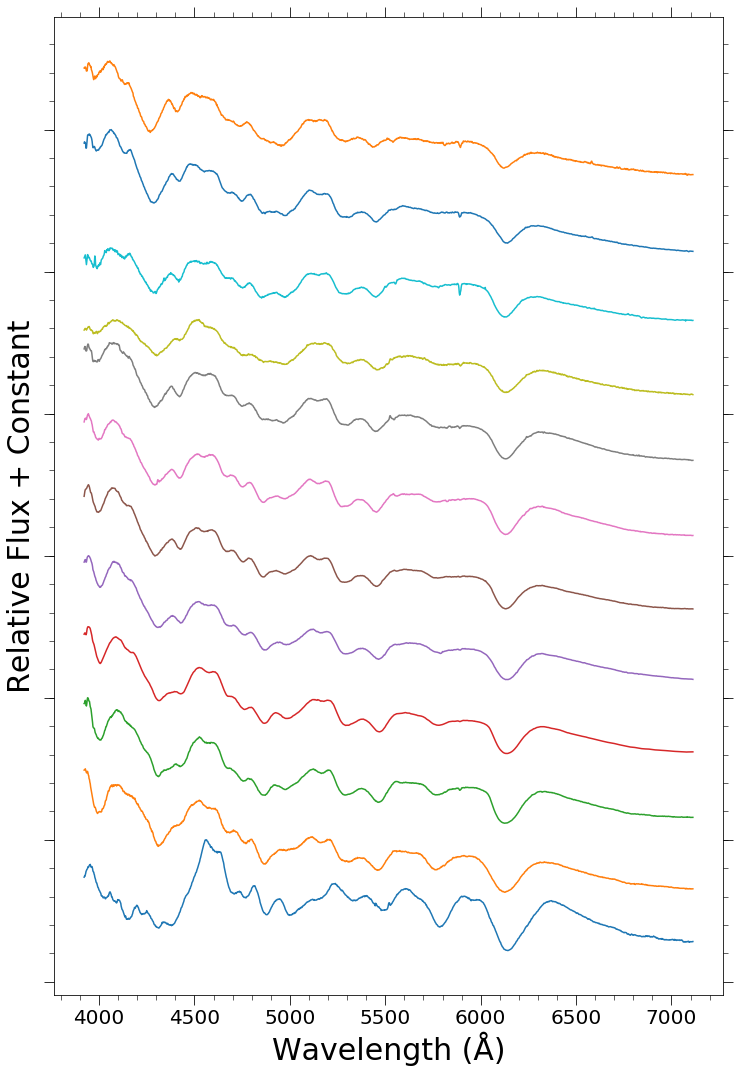

In [13]:
plt.figure(figsize=(12,18))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

k = 0

for composite in composites:
    wavelength = composite.wavelength[MIN:(MAX + 1)]
    flux = composite.flux[MIN:(MAX + 1)]
    plt.plot(wavelength, flux + k)
    k += 0.5

plt.savefig('../../dm15_Composites.png', dpi = 300, bbox_inches = 'tight')
plt.show()